In [1]:
from google.colab import files
data = files.upload()

Saving crime data.csv to crime data.csv


In [0]:
import io
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

C= pd.read_csv(io.BytesIO(data['crime data.csv']))

In [3]:
C.head() #checking the data

,City,Population,Violent crime,Murder,Rape (revised definition),Rape (legacy definition),Robbery,Aggravated assault,Property crime,Burglary,Larceny-theft,Motor Vehicle theft,Arson
0,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0,NaN,3,4,16,223,53,165,5,NaN


In [4]:
CF = pd.get_dummies(C['City'])
CF['Murder!'] = np.where(C['Murder']>0, 1, 0)
CF.head(5) #Making dummy variables take on city names and discretizing Murder

,Adams Village,Addison Town and Village,Akron Village,Albany,Albion Village,Alfred Village,Allegany Village,Amherst Town,Amityville Village,Amsterdam,Arcade Village,Ardsley Village,Asharoken Village,Attica Village,Auburn,Avon Village,Baldwinsville Village,Ballston Spa Village,Batavia,Bath Village,Bedford Town,Bethlehem Town,Binghamton,Black River,Blooming Grove Town,Bolivar Village,Bolton Town,Boonville Village,Brant Town,Brewster,Briarcliff Manor Village,Brighton Town,Brockport Village,Bronxville Village,Brownville Village,Buffalo,Cairo Town,Cambridge Village,Camden Village,Camillus Town and Village,...,Suffern Village,Syracuse,Tarrytown Village,Ticonderoga Town,Tonawanda,Tonawanda Town,Troy,Trumansburg Village,Tuckahoe Village,Tupper Lake Village,Tuxedo Park Village,Ulster Town,Utica,Vestal Town,Walden Village,Wallkill Town,Walton Village,Warsaw Village,Washingtonville Village,Waterford Town and Village,Waterloo Village,Watertown,Watervliet,Watkins Glen Village,Waverly Village,Webster Town and Village,Weedsport Village,Wellsville Village,West Seneca Town,Westhampton Beach Village,White Plains,Whitehall Village,Whitesboro Village,Whitestown Town,Woodbury Town,Woodridge Village,Woodstock Town,Yonkers,Yorktown Town,Murder!
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# C['Robbery'] = pd.to_numeric(C['Robbery'])

C['Robbery'] = C['Robbery'].str.replace("," , "").astype(float) #Removing commas and changing dtype to float otherwise I cannot discretize Robbery


In [6]:
C.dtypes

City                          object
Population                    object
Violent crime                 object
Murder                         int64
Rape (revised definition)    float64
Rape (legacy definition)      object
Robbery                      float64
Aggravated assault            object
Property crime                object
Burglary                      object
Larceny-theft                 object
Motor Vehicle theft           object
Arson                        float64
dtype: object

In [7]:
CF['Robbery'] = np.where(C['Robbery']>0, 1, 0)
CF.head() #discretizing 

,Adams Village,Addison Town and Village,Akron Village,Albany,Albion Village,Alfred Village,Allegany Village,Amherst Town,Amityville Village,Amsterdam,Arcade Village,Ardsley Village,Asharoken Village,Attica Village,Auburn,Avon Village,Baldwinsville Village,Ballston Spa Village,Batavia,Bath Village,Bedford Town,Bethlehem Town,Binghamton,Black River,Blooming Grove Town,Bolivar Village,Bolton Town,Boonville Village,Brant Town,Brewster,Briarcliff Manor Village,Brighton Town,Brockport Village,Bronxville Village,Brownville Village,Buffalo,Cairo Town,Cambridge Village,Camden Village,Camillus Town and Village,...,Syracuse,Tarrytown Village,Ticonderoga Town,Tonawanda,Tonawanda Town,Troy,Trumansburg Village,Tuckahoe Village,Tupper Lake Village,Tuxedo Park Village,Ulster Town,Utica,Vestal Town,Walden Village,Wallkill Town,Walton Village,Warsaw Village,Washingtonville Village,Waterford Town and Village,Waterloo Village,Watertown,Watervliet,Watkins Glen Village,Waverly Village,Webster Town and Village,Weedsport Village,Wellsville Village,West Seneca Town,Westhampton Beach Village,White Plains,Whitehall Village,Whitesboro Village,Whitestown Town,Woodbury Town,Woodridge Village,Woodstock Town,Yonkers,Yorktown Town,Murder!,Robbery
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
C['Population'] = C['Population'].str.replace(',' , '').astype(float) # Cleaning up the population column

# Adding my last two features
CF['pop'] = C['Population']
CF['pop^2'] = (C.Population)**2
CF.head()

,Adams Village,Addison Town and Village,Akron Village,Albany,Albion Village,Alfred Village,Allegany Village,Amherst Town,Amityville Village,Amsterdam,Arcade Village,Ardsley Village,Asharoken Village,Attica Village,Auburn,Avon Village,Baldwinsville Village,Ballston Spa Village,Batavia,Bath Village,Bedford Town,Bethlehem Town,Binghamton,Black River,Blooming Grove Town,Bolivar Village,Bolton Town,Boonville Village,Brant Town,Brewster,Briarcliff Manor Village,Brighton Town,Brockport Village,Bronxville Village,Brownville Village,Buffalo,Cairo Town,Cambridge Village,Camden Village,Camillus Town and Village,...,Ticonderoga Town,Tonawanda,Tonawanda Town,Troy,Trumansburg Village,Tuckahoe Village,Tupper Lake Village,Tuxedo Park Village,Ulster Town,Utica,Vestal Town,Walden Village,Wallkill Town,Walton Village,Warsaw Village,Washingtonville Village,Waterford Town and Village,Waterloo Village,Watertown,Watervliet,Watkins Glen Village,Waverly Village,Webster Town and Village,Weedsport Village,Wellsville Village,West Seneca Town,Westhampton Beach Village,White Plains,Whitehall Village,Whitesboro Village,Whitestown Town,Woodbury Town,Woodridge Village,Woodstock Town,Yonkers,Yorktown Town,Murder!,Robbery,pop,pop^2
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1861.0,3.463321e+06
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2577.0,6.640929e+06
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2846.0,8.099716e+06
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,97956.0,9.595378e+09
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6388.0,4.080654e+07


In [9]:
# Property Crime = alpha + population + (population)^2 + Murder + Robbery
C['Property crime'] = C['Property crime'].str.replace(',' , '').astype(float) # fixing the property crime column. cleaning never ends

import math
import warnings

from IPython.display import display
from sklearn import linear_model
import statsmodels.formula.api as smf


regr = linear_model.LinearRegression()
Y = C['Property crime'].values.reshape(-1, 1)
X = CF[['pop','pop^2','Murder!', 'Robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 3.46570268e-02 -2.11108019e-09  1.51866535e+01 -9.62774363e+01]]

Intercept: 
 [-109.57533562]

R-squared:
0.9961247104988709


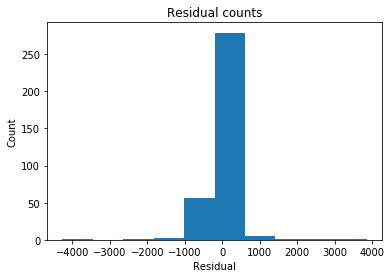

In [10]:

predicted = regr.predict(X).ravel()
actual = C['Property crime']

residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

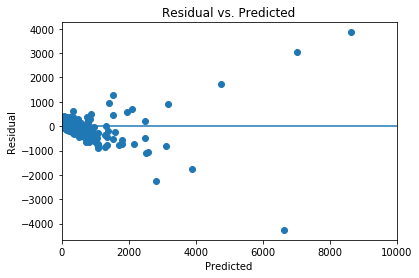

In [11]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.xlim(0,10000) #an outlier at 140,000 messes with the graph otherwise
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

At this point I need to decide how I would like to modify my model. I do not see the value in population^2 as a feature or murder for that matter when trying to predict Property Crime. I'm going to drop murder feature and use some more appropriate ones. Additionally my accuracy is very high which suggests some overfitting. My error counts are heavily centered at zero and my scedasticity seems acceptable.

my solutions is

Property Crime = alpha + population + population^2 + arson + MVT + Burglary + Lacrceny-Theft + Robbery

My reasoning is that all the examples above are examples of property crime. Murder is a different class of crime and unrelated so it was dropped. 

In [15]:
# C['Motor Vehicle theft'] = C['Motor Vehicle theft'].str.replace(',' , '').astype(float)
C['Burglary'] = C['Burglary'].str.replace(',' , '').astype(float)
C['Larceny-theft'] = C['Larceny-theft'].str.replace(',' , '').astype(float)


CF['Arson'] = np.where(C['Arson']>0, 1, 0)
CF['MVT'] = np.where(C['Motor Vehicle theft']>0, 1,0)
CF['Burglary'] = np.where(C['Burglary']>0, 1,0)
CF['Larceny'] = np.where(C['Larceny-theft']>0, 1,0)
CF['prop crime'] = C['Property crime']
CF.head()

,Adams Village,Addison Town and Village,Akron Village,Albany,Albion Village,Alfred Village,Allegany Village,Amherst Town,Amityville Village,Amsterdam,Arcade Village,Ardsley Village,Asharoken Village,Attica Village,Auburn,Avon Village,Baldwinsville Village,Ballston Spa Village,Batavia,Bath Village,Bedford Town,Bethlehem Town,Binghamton,Black River,Blooming Grove Town,Bolivar Village,Bolton Town,Boonville Village,Brant Town,Brewster,Briarcliff Manor Village,Brighton Town,Brockport Village,Bronxville Village,Brownville Village,Buffalo,Cairo Town,Cambridge Village,Camden Village,Camillus Town and Village,...,Tuckahoe Village,Tupper Lake Village,Tuxedo Park Village,Ulster Town,Utica,Vestal Town,Walden Village,Wallkill Town,Walton Village,Warsaw Village,Washingtonville Village,Waterford Town and Village,Waterloo Village,Watertown,Watervliet,Watkins Glen Village,Waverly Village,Webster Town and Village,Weedsport Village,Wellsville Village,West Seneca Town,Westhampton Beach Village,White Plains,Whitehall Village,Whitesboro Village,Whitestown Town,Woodbury Town,Woodridge Village,Woodstock Town,Yonkers,Yorktown Town,Murder!,Robbery,pop,pop^2,Arson,MVT,Burglary,Larceny,prop crime
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1861.0,3.463321e+06,0,0,1,1,12.0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2577.0,6.640929e+06,0,1,1,1,24.0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2846.0,8.099716e+06,0,0,1,1,16.0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,97956.0,9.595378e+09,0,1,1,1,4090.0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6388.0,4.080654e+07,0,1,1,1,223.0


In [17]:
custom = linear_model.LinearRegression()
Y = CF['prop crime'].values.reshape(-1, 1)
X = CF[['pop','pop^2','Arson', 'MVT', 'Burglary', 'Larceny', 'Robbery']]
custom.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', custom.coef_)
print('\nIntercept: \n', custom.intercept_)
print('\nR-squared:')
print(custom.score(X, Y))


Coefficients: 
 [[ 3.50379740e-02 -2.15613883e-09 -3.24574189e+01 -7.83672489e+01
  -4.89200220e+01  9.83097430e+00 -5.71532562e+01]]

Intercept: 
 [-38.21880526]

R-squared:
0.9961478603048148
